Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Plot the distribution of your target. 
    - Regression problem: Is your target skewed? Then, log-transform it.
    - ---> Classification: Are your classes imbalanced? Then, don't use just accuracy. And try `class_balance` parameter in scikit-learn.
- [X] Continue to clean and explore your data. Make exploratory visualizations.
- [X] Fit a model. Does it beat your baseline?
- idk why it gave me a roc score of 1...so like nearly 100% but I highly doubt that. Need to investigate what I did wrong.
- [X] Share at least 1 visualization on Slack.

You need to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

### Today
- [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)
- [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)
- [Machine Learning Meets Economics](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)


### Yesterday
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [How Shopify Capital Uses Quantile Regression To Help Merchants Succeed](https://engineering.shopify.com/blogs/engineering/how-shopify-uses-machine-learning-to-help-our-merchants-grow-their-business)
- [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), **by Lambda DS3 student** Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)






In [1]:
import sys, getpass
a = getpass.getuser()
### example appending of folder
sys.path.append('/Users/{}/Programs/BFLibrary/'.format(a))

In [2]:
#from BFLibrary import ACompass, BWarp, CToolbox 
import AMap as am
import BCook as bc
import CTools as ct

In [3]:
import pandas as pd
pd.options.display.float_format = None
df = pd.read_excel('~/Downloads/CoralBleaching.xlsm')

In [4]:
target = 'BLEACHING_SEVERITY'

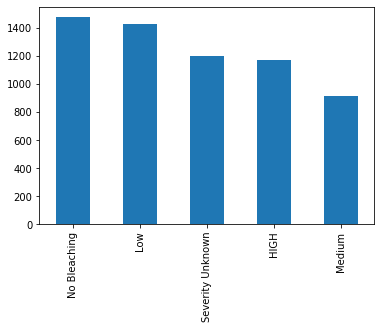

In [5]:
df[target].value_counts().plot(kind='bar')

In [6]:
### Since I'm doing classification maybe I should just group it into bleaching and non-bleaching.
## No doubt it'll be above 65% for majority classification so maybe I'll have to use something other
## than just accuracy.

# Let's group by bleaching or not.
df[target] = df[target].replace({
    'Low':1, 'HIGH':1, 'Medium':1, 'Severity Unknown':1,
    'No Bleaching':0})

### ID 29433 LAT is actually -10.269
df['LAT'] = df['LAT'].replace({-10269:-10.269})

df.drop('ID', axis=1, inplace=True)

In [7]:
features, num_feats, cat_feats = bc.allPantryFeatures(df)

In [8]:
### Drop some columns w/ almost no values
df = bc.diceBadCols(df, features, percent=60)

In [9]:
pd.value_counts(df[target].values,sort=True)

1    4713
0    1477
dtype: int64

In [10]:
pd.value_counts(df.YEAR,sort=False).sort_index()

1963       1
1969       2
1973       1
1976       1
1977       1
1979       6
1980      11
1981       2
1982      20
1983      48
1984       2
1985       3
1986      12
1987      86
1988       2
1989       4
1990      11
1991      13
1992      46
1993      11
1994      97
1995      27
1996      21
1997      44
1998    2054
1999     177
2000     170
2001     213
2002     824
2003     257
2004     297
2005     668
2006     298
2007     124
2008     140
2009     188
2010     205
2011      63
2012      40
Name: YEAR, dtype: int64

In [11]:
test_mask = (df['YEAR'] > 2005)
val_mask = (
    (df['YEAR'] > 2003) &
    (df['YEAR'] <= 2005)
)
train_mask = (df['YEAR'] <= 2003)
test = df[test_mask]
train = df[train_mask]
val = df[val_mask]
print(train.shape, val.shape, test.shape,"\n",
      "Sum of shapes:", train.shape[0]+val.shape[0]+test.shape[0],"\n",
      "Total dataframe shape:", df.shape[0])

# Get features again after I chopped em'
features, num_feats, cat_feats = bc.allPantryFeatures(train)

X_train = train[features].drop(target,axis=1)
y_train = train[target]
X_val = val[features].drop(target,axis=1)
y_val = val[target]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(4167, 14) (965, 14) (1058, 14) 
 Sum of shapes: 6190 
 Total dataframe shape: 6190
(4167, 13) (4167,) (965, 13) (965,)


In [12]:
y_train.value_counts(normalize=True)

1    0.75594
0    0.24406
Name: BLEACHING_SEVERITY, dtype: float64

Baseline model is 76% majority class (bleached)... so yeah.

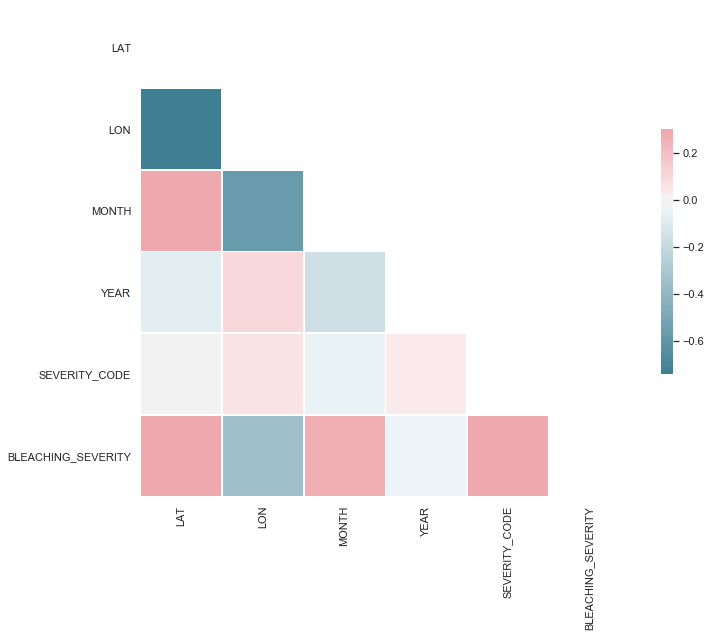

In [13]:
am.heatSeeker(train)

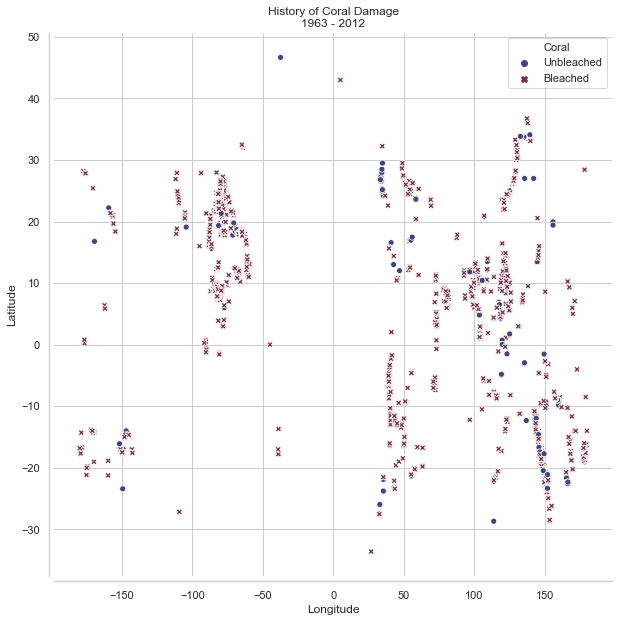

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot


#sns.catplot?
#sns.catplot(data=train,x="LON",y="LAT", hue=target)
sns.set_style("whitegrid")

dims = (10,10)
fig, ax = pyplot.subplots(figsize=dims) 

markers = {0:"o",1:"x"}
g = sns.scatterplot(data=df,x="LON",y="LAT", hue=target,
                    palette='icefire', style=df.BLEACHING_SEVERITY)
sns.set_style("whitegrid")
sns.despine(offset=5, trim=False)
'''sns.axes_style({'axes.spines.bottom': False,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': False})''';
leg = plt.legend(frameon=False)
handles, labels = ax.get_legend_handles_labels()
labels = ['Coral','Unbleached','Bleached']
ax.legend(handles, labels)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.title("History of Coral Damage\n1963 - 2012")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show(g)

//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


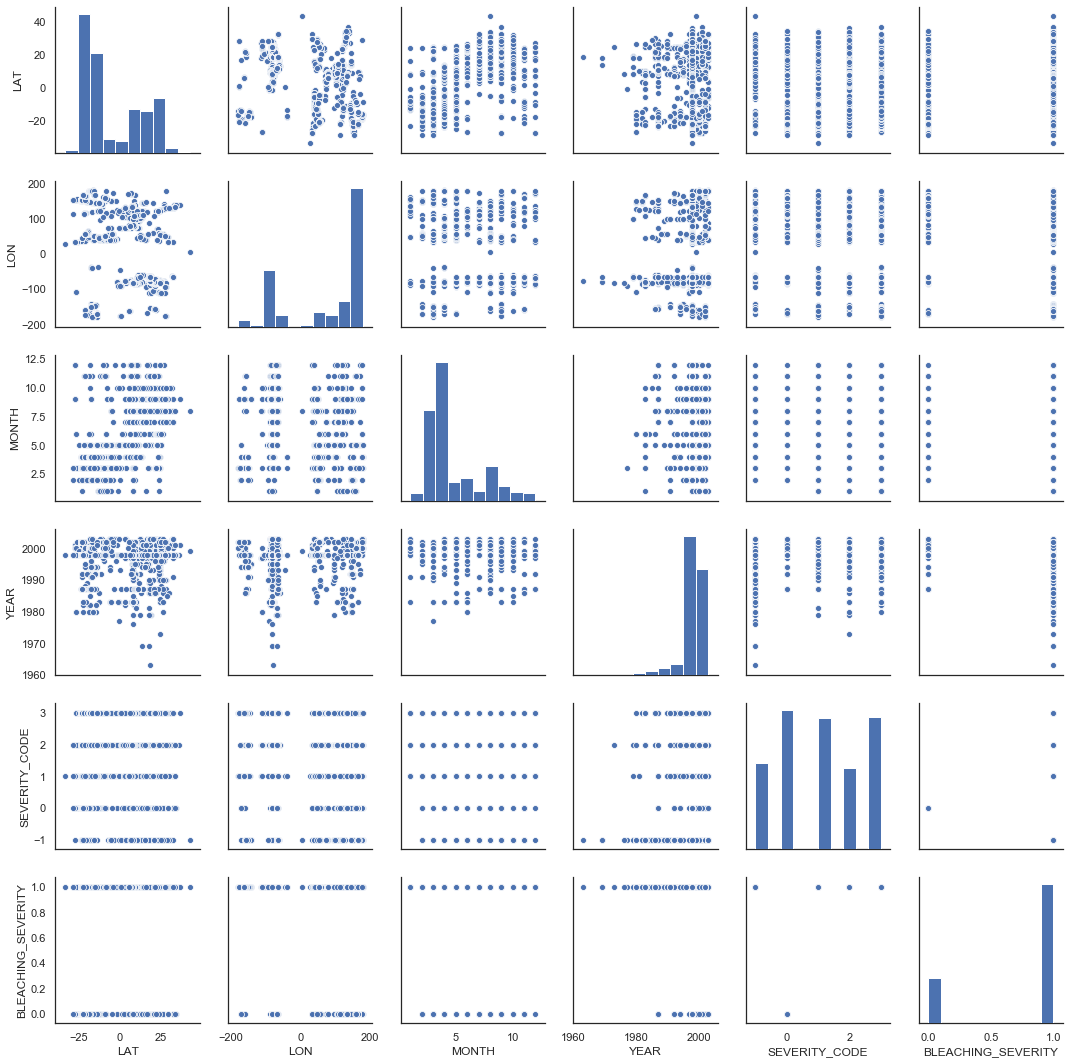

In [15]:
sns.pairplot(train)

In [16]:
%%time

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=4)
)
pipeline.fit(X_train,y_train)

CPU times: user 290 ms, sys: 43.5 ms, total: 334 ms
Wall time: 293 ms


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['REGION', 'SUBREGION', 'COUNTRY',
                                      'LOCATION', 'DEPTH', 'REMARKS', 'SOURCE',
                                      'COUNTRY_CODE'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'REGION',
                                          'data_type': dtype('O'),
                                          'mapping': NaN            1
Africa         2
Americas       3
Asia           4
Australia      5
Middle East    6
Pacific        7
dtype: int64},
                                         {'col'...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_fe

In [17]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
accuracy_score(y_val,y_pred)

0.8787564766839379

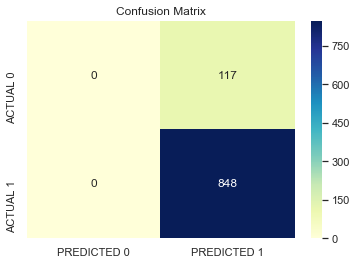

In [18]:
am.plotConfusionMatrix(y_val,y_pred)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.88      1.00      0.94       848

    accuracy                           0.88       965
   macro avg       0.44      0.50      0.47       965
weighted avg       0.77      0.88      0.82       965



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

1.0